In [4]:
import pandas as pd

# get embedding vectors - each row is a job posting, each column is a feature
embeddings = pd.read_csv('text_embeddings.csv', index_col=0)

all_postings = pd.read_csv('processed_description.csv', index_col=0)

text = all_postings['processed_description']
salary_bins = all_postings['salary_bin']
salary_ranges = all_postings['salary_range']





## Split train, validation, and test set: 


In [5]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(embeddings, salary_bins, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Logistic Regression

In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc

model = LogisticRegression(max_iter=1000, C = 1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)



print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('AUROC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))





Accuracy: 0.5913857677902622
F1: 0.5878727474522593
AUROC: 0.8310688877372037


## Random Forest Classifier

In [225]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))



Accuracy: 0.6232209737827715
F1: 0.6154045287037953
ROC AUC: 0.8575517089215852


## XGBoost

In [230]:
import xgboost as xgb

xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=5, max_depth=20, n_estimators=100)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))



Accuracy: 0.6333333333333333
F1: 0.6307232785335142
ROC AUC: 0.8663795074185793


## Feed Forward Network

In [ ]:
#  feedforward
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100,50) , max_iter=1000, learning_rate='adaptive')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='weighted'))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))



Accuracy: 0.601123595505618
F1: 0.6018189006020477
ROC AUC: 0.8058940526022109


In [10]:
# create train and test loaders
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)




In [8]:
device = 'mps'
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from torch.nn import functional as F
def train(epoch, model, optimizer, verbose=False):
    model.train()
    epoch_loss = 0
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data to device, where the "device" is either a GPU if it exists or a CPU
        data, target = data.to(device), target.to(device)
        
       
        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        loss = F.cross_entropy(output, target)
        # backward pass through the cross-entropy loss function and the model
        loss.backward()
        
        optimizer.step()
        if batch_idx % 50 == 0:
            losses.append(loss.detach())
            if verbose :
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, verbose=False):
    model.eval()
    accuracy_list = []
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # send data to device, where the "device" is either a GPU if it exists or a CPU
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss                                                               
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability      
                                                                       
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        accuracy_list.append(accuracy) 
        if verbose :
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                accuracy))
    return test_loss
        
    
  



### LSTM Model (RNN Variant)
Long Short-Term Memory layer in a neural netowrk model perform well in tasks involve learning long-term dependencies in sequential data, addressing limitation of a traditional RNN.

In [2]:
from torch import nn, optim
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    


In [11]:
embedding_dim = embeddings.shape[1]
hidden_dim = 100
output_dim = 4
num_layers = 2


model = LSTMModel(embedding_dim, hidden_dim, num_layers, output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

for epoch in range(0, 10):
    train(epoch, model, optimizer, verbose=True)
    test(model, verbose=True)
    




Train Epoch: 0 [0/8544 (0%)]	Loss: 1.360113
Train Epoch: 0 [400/8544 (5%)]	Loss: 1.447664
Train Epoch: 0 [800/8544 (9%)]	Loss: 1.357509
Train Epoch: 0 [1200/8544 (14%)]	Loss: 1.448613
Train Epoch: 0 [1600/8544 (19%)]	Loss: 1.222051
Train Epoch: 0 [2000/8544 (23%)]	Loss: 1.213048
Train Epoch: 0 [2400/8544 (28%)]	Loss: 1.373495
Train Epoch: 0 [2800/8544 (33%)]	Loss: 1.253343
Train Epoch: 0 [3200/8544 (37%)]	Loss: 1.418324
Train Epoch: 0 [3600/8544 (42%)]	Loss: 1.254537
Train Epoch: 0 [4000/8544 (47%)]	Loss: 0.943082
Train Epoch: 0 [4400/8544 (51%)]	Loss: 1.004066
Train Epoch: 0 [4800/8544 (56%)]	Loss: 0.854597
Train Epoch: 0 [5200/8544 (61%)]	Loss: 1.077396
Train Epoch: 0 [5600/8544 (66%)]	Loss: 0.650803
Train Epoch: 0 [6000/8544 (70%)]	Loss: 1.019565
Train Epoch: 0 [6400/8544 (75%)]	Loss: 0.950226
Train Epoch: 0 [6800/8544 (80%)]	Loss: 0.900693
Train Epoch: 0 [7200/8544 (84%)]	Loss: 1.078555
Train Epoch: 0 [7600/8544 (89%)]	Loss: 1.031487
Train Epoch: 0 [8000/8544 (94%)]	Loss: 1.134802


In [12]:
# get performance metrics - f1, roc_auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.nn import functional as F

def get_metrics(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    y_pred_proba = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy().flatten())
            y_pred_proba.extend(F.softmax(output, dim=1).cpu().numpy())
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='weighted'), roc_auc_score(y_true, y_pred_proba, multi_class='ovr')

accuracy, f1, roc_auc = get_metrics(model, test_loader)
print('Accuracy:', accuracy)
print('F1:', f1)
print('ROC AUC:', roc_auc)




Accuracy: 0.599625468164794
F1: 0.5966436581030964
ROC AUC: 0.8356409092340128


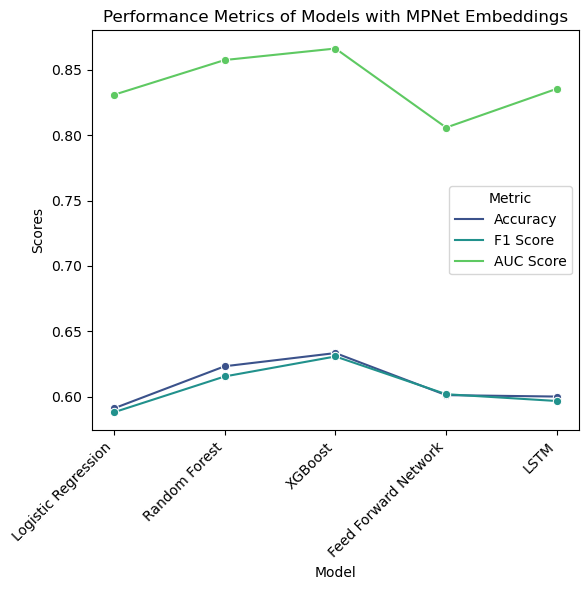

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Models
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Feed Forward Network', 'LSTM']
accuracy = [0.591, 0.6232, 0.6333, 0.6011, 0.6]
f1_score = [0.588, 0.6154, 0.6307, 0.6018, 0.5966]
auc_score = [0.831, 0.8576, 0.8664, 0.8059, 0.8356]  

# Create a DataFrame for the data
import pandas as pd
data = pd.DataFrame({'Model': models*3,
                     'Metric': ['Accuracy']*5 + ['F1 Score']*5 + ['AUC Score']*5,
                     'Score': accuracy + f1_score + auc_score})

# Plot using Seaborn
plt.figure(figsize=(6, 6))
sns.lineplot(x='Model', y='Score', hue='Metric', marker='o', data=data, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Performance Metrics of Models with MPNet Embeddings')
plt.ylabel('Scores')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()
